Successfully loaded data from D:/data_for_seg/
Successfully loaded data from E:/data_for_seg/


[14:22:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[14:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[14:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[14:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[14:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


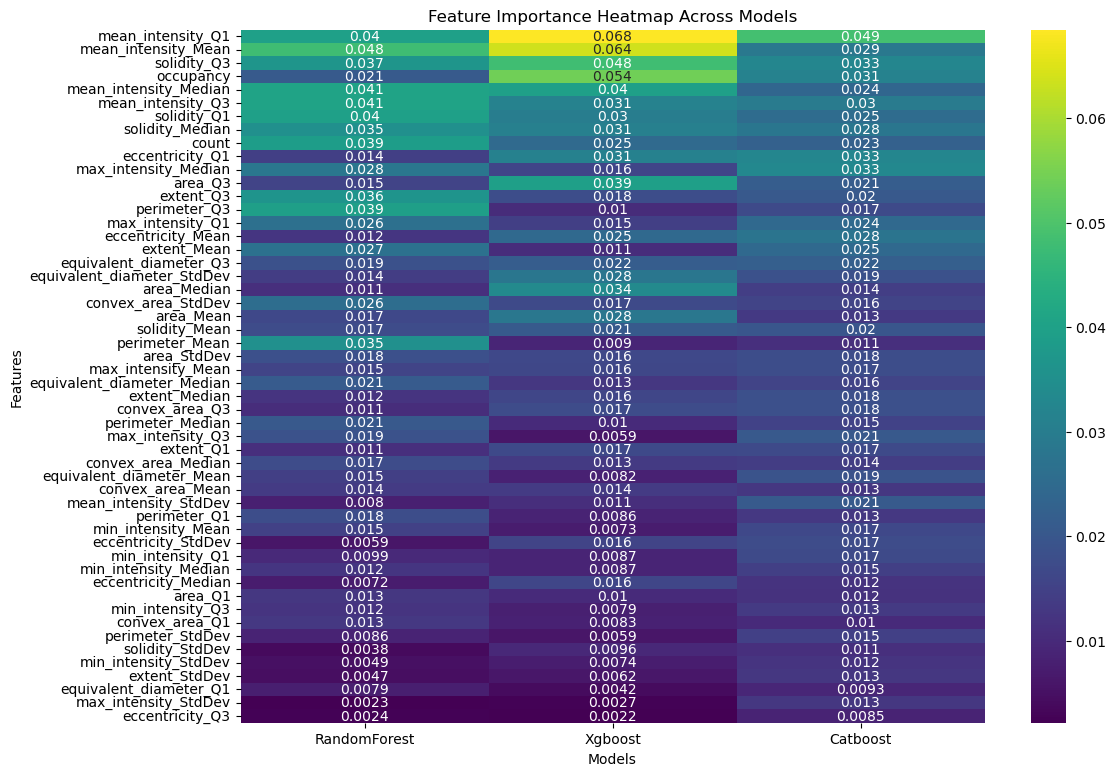

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.spatial import Voronoi, voronoi_plot_2d
import umap.umap_ as umap
from importlib import reload
import utility
reload(utility)
from utility import get_hard_disk_path

# Your utility imports and functions
from utility import load_data, train_model, get_shap, get_hard_disk_path

random_state = 42
csv_path = "statistics_features_IP_Q1_Q3.csv"
X, y, unique_labels, label_mapping, data = load_data(get_hard_disk_path("Segmentation"), csv_path)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Initialize a matrix to store cumulative SHAP values for each model
cumulative_shap_values = {model_name: np.zeros(len(X.columns)) for model_name in ["RandomForest", "Xgboost", "Catboost"]}

# Perform cross-validation
for train_ix, test_ix in kf.split(X, y):
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train each model and accumulate SHAP values
    for model_name in ["RandomForest", "Xgboost", "Catboost"]:
        classifier = train_model(X_train, y_train, unique_labels, model_name, random_state=random_state)
        shap_values = get_shap(classifier, X_test)

        # Check if shap_values is a list (multi-class scenario)
        if isinstance(shap_values, list):
            # Flatten the list of SHAP values arrays into a single 1D array by averaging across classes and then summing across features
            shap_values = np.sum([np.mean(np.abs(sv), axis=0) for sv in shap_values], axis=0)

        # Ensure shap_values is now a 1D array
        if len(shap_values.shape) != 1:
            raise ValueError(f"Unexpected SHAP values shape: {shap_values.shape}")

        # Check if the shapes match
        if shap_values.shape[0] != cumulative_shap_values[model_name].shape[0]:
            raise ValueError(f"Shape mismatch: SHAP values shape {shap_values.shape} does not match expected shape {cumulative_shap_values[model_name].shape}")

        cumulative_shap_values[model_name] += shap_values

# Normalize SHAP values for each model
normalized_shap_values = {model: values / np.sum(values) if np.sum(values) != 0 else values for model, values in cumulative_shap_values.items()}

# Concatenate normalized SHAP values for each model into a single matrix
concatenated_shap_values = np.column_stack(list(normalized_shap_values.values()))

# Sum the normalized SHAP values across all models for each feature
sum_shap_values_across_models = concatenated_shap_values.sum(axis=1)

# Normalize across all models
final_normalized_shap_values = sum_shap_values_across_models / sum_shap_values_across_models.sum()

# Get the indices of the 10 features with the highest sums
top_10_feature_indices = np.argsort(final_normalized_shap_values)[-10:][::-1]

# Extract the names of the top 10 features
top_10_feature_names = X.columns[top_10_feature_indices]

# Order the features based on the sum of SHAP values
ordered_indices = np.argsort(final_normalized_shap_values)[::-1]
ordered_shap_values_matrix = concatenated_shap_values[ordered_indices, :]

# Creating the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(ordered_shap_values_matrix, cmap='viridis', yticklabels=X.columns[ordered_indices], xticklabels=["RandomForest", "Xgboost", "Catboost"], annot=True)
plt.title("Feature Importance Heatmap Across Models")
plt.ylabel("Features")
plt.xlabel("Models")
plt.show()

In [4]:
# Extract the names of the top 10 features
top_feature_names = X.columns[ordered_indices]
print(X.shape[0], X.shape[1])

107 52


In [5]:
X = X.drop(X[(X['count'] == 0) | (X['count'] == 1)].index)
print(X.shape[0], X.shape[1])

104 52


In [6]:
features_mean_std = []
for feature in top_feature_names:
    if "_" in feature:
        last_part = feature.split("_")[-1]
        if last_part == "Min" or last_part == "Max":
            continue
    features_mean_std.append(feature)

print(features_mean_std)


['mean_intensity_Q1', 'mean_intensity_Mean', 'solidity_Q3', 'occupancy', 'mean_intensity_Median', 'mean_intensity_Q3', 'solidity_Q1', 'solidity_Median', 'count', 'eccentricity_Q1', 'max_intensity_Median', 'area_Q3', 'extent_Q3', 'perimeter_Q3', 'max_intensity_Q1', 'eccentricity_Mean', 'extent_Mean', 'equivalent_diameter_Q3', 'equivalent_diameter_StdDev', 'area_Median', 'convex_area_StdDev', 'area_Mean', 'solidity_Mean', 'perimeter_Mean', 'area_StdDev', 'max_intensity_Mean', 'equivalent_diameter_Median', 'extent_Median', 'convex_area_Q3', 'perimeter_Median', 'max_intensity_Q3', 'extent_Q1', 'convex_area_Median', 'equivalent_diameter_Mean', 'convex_area_Mean', 'mean_intensity_StdDev', 'perimeter_Q1', 'min_intensity_Mean', 'eccentricity_StdDev', 'min_intensity_Q1', 'min_intensity_Median', 'eccentricity_Median', 'area_Q1', 'min_intensity_Q3', 'convex_area_Q1', 'perimeter_StdDev', 'solidity_StdDev', 'min_intensity_StdDev', 'extent_StdDev', 'equivalent_diameter_Q1', 'max_intensity_StdDev', '

In [7]:
print(X.shape[0], X.shape[1])

104 52


Successfully loaded data from D:/data_for_seg/
Successfully loaded data from E:/data_for_seg/


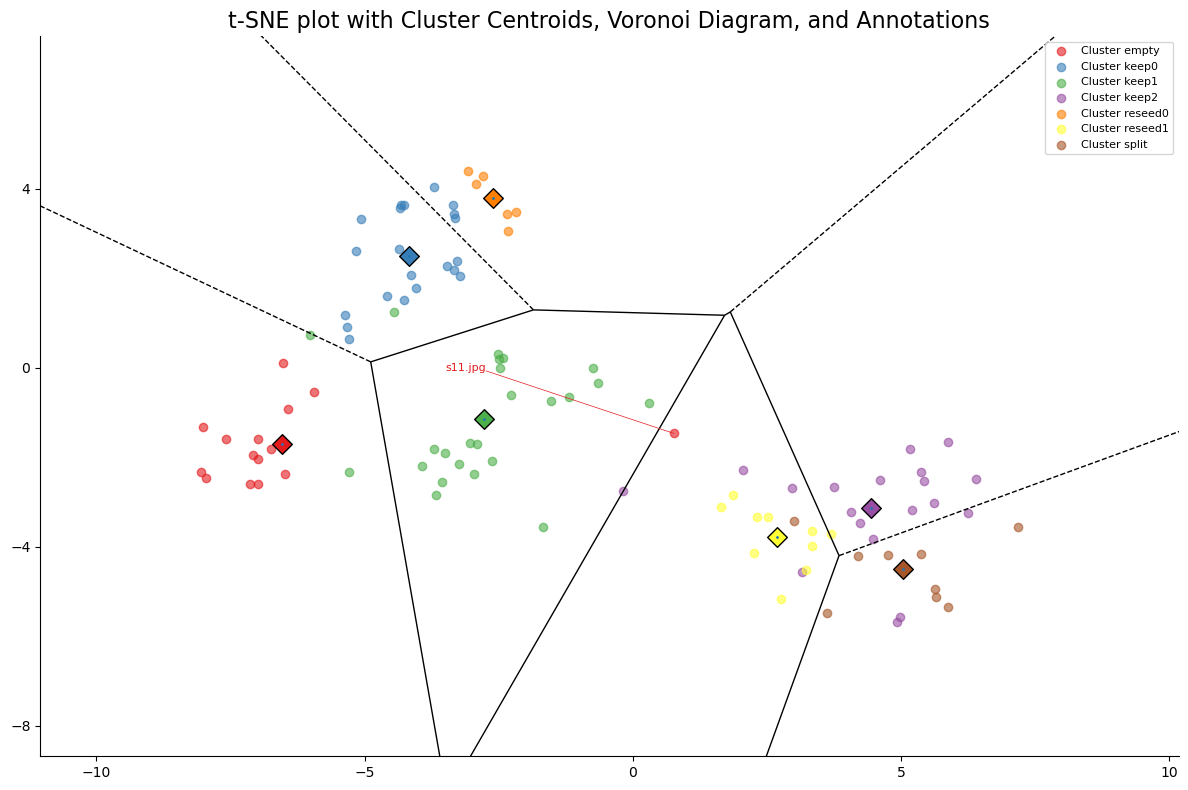

In [8]:
# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path("Segmentation") + csv_path)

data = data.drop(data[(data['count'] == 0) | (data['count'] == 1)].index)

# Save image names for later use in annotation
image_names = data['image_name']

# Dropping the 'image_name' column as it's not needed for t-SNE
features = data.drop('image_name', axis=1)

# Saving the labels for later use in the plot
labels = features['label']

data = features.copy()

# Dropping the 'label' column to scale only numerical features
features = features.drop('label', axis=1)

features = features[top_feature_names]

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Now let's perform t-SNE on the scaled features
tsne = TSNE(n_components=2, random_state=0)  # using 2 components for a 2D plot
# The fit might take a long time, depending on the size of your dataset
tsne_results = tsne.fit_transform(features_scaled)

unique_labels = np.unique(labels)
centroids = np.array([tsne_results[labels == label].mean(axis=0) for label in unique_labels])

vor = Voronoi(centroids)

# Start plot design enhancements here
fig, ax = plt.subplots(figsize=(12, 8))  # Larger figure size

# Step 4: Plot the t-SNE points and centroids
palette = plt.cm.Set1  # A nicer color map

for i, label in enumerate(unique_labels):
    points = tsne_results[labels == label]
    centroid = centroids[i]
    color = palette(i)
    
    ax.scatter(points[:, 0], points[:, 1], color=color, alpha=0.6, label=f'Cluster {label}')
    ax.scatter(centroid[0], centroid[1], color=color, edgecolors='black', marker='D', s=100)  # Diamond-shaped centroids

# Step 5: Overlay Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, point_size=2)

# Create a mapping from label to integer index
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Define function to get random label positions
def get_label_pos(point, offset=4.07):
    # Randomly choose an offset direction
    dx, dy = random.uniform(-offset, offset), random.uniform(-offset, offset)
    return point + np.array([dx, dy])

# Annotate far away points with lines
threshold = 7  # Define a suitable threshold
for i, (point, name, label) in enumerate(zip(tsne_results, image_names, data['label'])):
    centroid_index = label_to_index[label]
    centroid = centroids[centroid_index]
    distance = np.linalg.norm(point - centroid)
    
    if distance > threshold:
        # Get random label position
        label_pos = get_label_pos(point)

        # Get color for the cluster
        color = palette(centroid_index)

        # Draw a line from point to label with the same color as the cluster
        ax.plot([point[0], label_pos[0]], [point[1], label_pos[1]], color=color, linestyle='-', linewidth=0.5)

        # Place text at the random label position
        ax.text(label_pos[0], label_pos[1], name, fontsize=8, ha='right', color=color)

# Enhancements
ax.set_title('t-SNE plot with Cluster Centroids, Voronoi Diagram, and Annotations', fontsize=16)
ax.legend(fontsize=8, loc='upper right')
# Set axis limits to the range of t-SNE results to avoid excessive whitespace
x_min, x_max = tsne_results[:, 0].min() - 3, tsne_results[:, 0].max() + 3
y_min, y_max = tsne_results[:, 1].min() - 3, tsne_results[:, 1].max() + 3
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()


Successfully loaded data from D:/data_for_seg/
Successfully loaded data from E:/data_for_seg/


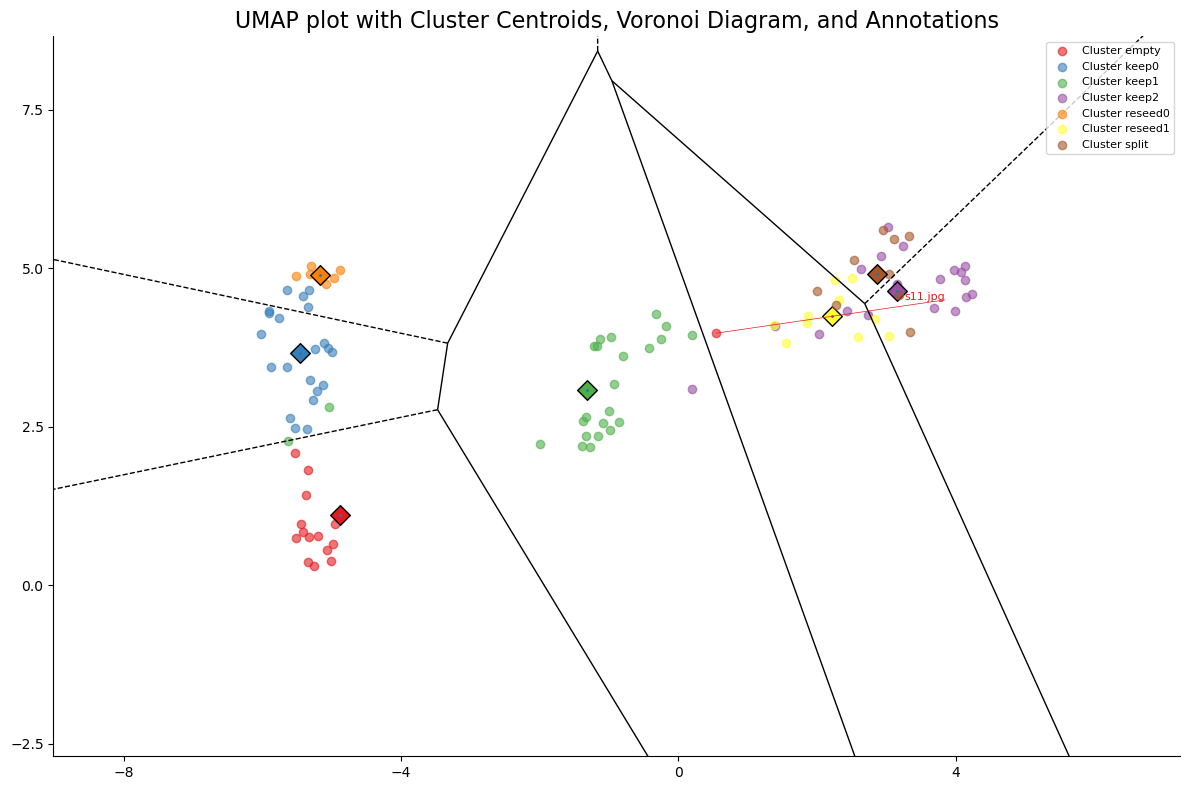

In [9]:
# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path("Segmentation") + csv_path)

data = data.drop(data[(data['count'] == 0) | (data['count'] == 1)].index)

# Save image names for later use in annotation
image_names = data['image_name']

# Dropping the 'image_name' and 'label' column
features = data.drop(['image_name', 'label'], axis=1)

# Select only top 10 features
features = features[top_feature_names]

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply UMAP
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42).fit_transform(features_scaled)

# Calculate centroids
unique_labels = np.unique(data['label'])
centroids = np.array([umap_results[data['label'] == label].mean(axis=0) for label in unique_labels])

# Calculate Voronoi
vor = Voronoi(centroids)

# Plot design
fig, ax = plt.subplots(figsize=(12, 8))

# Plot UMAP points and centroids
palette = plt.cm.Set1

for i, label in enumerate(unique_labels):
    points = umap_results[data['label'] == label]
    centroid = centroids[i]
    color = palette(i)
    
    ax.scatter(points[:, 0], points[:, 1], color=color, alpha=0.6, label=f'Cluster {label}')
    ax.scatter(centroid[0], centroid[1], color=color, edgecolors='black', marker='D', s=100)

# Overlay Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, point_size=2)

# Create a mapping from label to integer index
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Define function to get random label positions
def get_label_pos(point, offset=4.07):
    # Randomly choose an offset direction
    dx, dy = random.uniform(-offset, offset), random.uniform(-offset, offset)
    return point + np.array([dx, dy])

# Annotate far away points with lines
threshold = 5  # Define a suitable threshold
for i, (point, name, label) in enumerate(zip(umap_results, image_names, data['label'])):
    centroid_index = label_to_index[label]
    centroid = centroids[centroid_index]
    distance = np.linalg.norm(point - centroid)
    
    if distance > threshold:
        # Get random label position
        label_pos = get_label_pos(point)

        # Get color for the cluster
        color = palette(centroid_index)

        # Draw a line from point to label with the same color as the cluster
        ax.plot([point[0], label_pos[0]], [point[1], label_pos[1]], color=color, linestyle='-', linewidth=0.5)

        # Place text at the random label position
        ax.text(label_pos[0], label_pos[1], name, fontsize=8, ha='right', color=color)

# Enhancements
ax.set_title('UMAP plot with Cluster Centroids, Voronoi Diagram, and Annotations', fontsize=16)
ax.legend(fontsize=8, loc='upper right')
x_min, x_max = umap_results[:, 0].min() - 3, umap_results[:, 0].max() + 3
y_min, y_max = umap_results[:, 1].min() - 3, umap_results[:, 1].max() + 3
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

# Your utility imports and functions
from utility import load_data, train_model, get_shap, get_hard_disk_path

random_state = 42
csv_path = "statistics_features_IP.csv"
X, y, unique_labels, label_mapping, data = load_data(get_hard_disk_path("Segmentation"), csv_path)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Initialize a dictionary to store SHAP values for each model, class, and fold
shap_values_per_fold = {fold: {model_name: {class_label: [] for class_label in unique_labels} for model_name in ["RandomForest", "Xgboost", "Catboost"]} for fold in range(kf.get_n_splits())}

fold_index = 0

# Perform cross-validation
for train_ix, test_ix in kf.split(X, y):
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train each model and accumulate SHAP values
    for model_name in ["RandomForest", "Xgboost", "Catboost"]:
        classifier = train_model(X_train, y_train, unique_labels, model_name, random_state=random_state)
        shap_values = get_shap(classifier, X_test)  # Ensure this returns SHAP values for each class

        # Store SHAP values for each class in the fold
        for class_label, class_shap_values in zip(unique_labels, shap_values):
            shap_values_per_fold[fold_index][model_name][class_label].append(np.abs(class_shap_values))

    fold_index += 1

# Average SHAP values across folds for each model and class
avg_shap_per_model_class = {model_name: {class_label: np.mean(np.vstack(shap_values_per_fold[fold][model_name][class_label]), axis=0) for class_label in unique_labels} for model_name in ["RandomForest", "Xgboost", "Catboost"] for fold in range(kf.get_n_splits())}

# Compute the average SHAP values across models for each class
avg_shap_across_models = {class_label: np.mean(np.array([avg_shap_per_model_class[model_name][class_label] for model_name in ["RandomForest", "Xgboost", "Catboost"]]), axis=0) for class_label in unique_labels}

# Aggregate SHAP values across all classes
total_shap_values = np.sum([values for values in avg_shap_across_models.values()], axis=0)

# Rank features by their importance (sum of SHAP values)
feature_importance_indices = np.argsort(-total_shap_values)

top_features = feature_importance_indices

# Prepare data for plotting
plot_data = np.array([avg_shap_across_models[class_label][top_features] for class_label in avg_shap_across_models]).T

# Feature names for the top N features
feature_names = [X.columns[i] for i in top_features]

# Class labels
class_labels = list(avg_shap_across_models.keys())

# Identify the index of the "dead" class
dead_class_index = class_labels.index("dead")

# Sort plot_data and feature_names based on the SHAP values for the "dead" class
sorted_indices = np.argsort(-plot_data[:, dead_class_index])
plot_data_sorted = plot_data[sorted_indices, :]
feature_names_sorted = [feature_names[i] for i in sorted_indices]

# Create heatmap with sorted data
plt.figure(figsize=(10, 8))
sns.heatmap(plot_data_sorted, annot=True, cmap='viridis', yticklabels=feature_names_sorted, xticklabels=class_labels)
plt.title("Top Feature Importance Across Classes (Sorted by 'Dead' Class)")
plt.ylabel("Top Features")
plt.xlabel("Classes")
plt.show()

Successfully loaded data from D:/data_for_seg/
Successfully loaded data from E:/data_for_seg/


TypeError: sklearn.ensemble._forest.RandomForestClassifier() argument after ** must be a mapping, not int

In [40]:
features_mean_std = []
for feature in feature_names_sorted:
    if "_" in feature:
        last_part = feature.split("_")[-1]
        if last_part == "Min" or last_part == "Max":
            continue
    features_mean_std.append(feature)

print(features_mean_std)

['count', 'extent_Mean', 'extent_StdDev', 'mean_intensity_Mean', 'solidity_Mean', 'occupancy', 'min_intensity_Mean', 'max_intensity_StdDev', 'equivalent_diameter_StdDev', 'max_intensity_Mean', 'perimeter_Mean', 'equivalent_diameter_Mean', 'mean_intensity_StdDev', 'solidity_StdDev', 'convex_area_Mean', 'area_Mean', 'min_intensity_StdDev', 'area_StdDev', 'convex_area_StdDev', 'eccentricity_StdDev', 'perimeter_StdDev', 'eccentricity_Mean']


In [41]:
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.spatial import Voronoi, voronoi_plot_2d
import umap.umap_ as umap
from importlib import reload
import utility
reload(utility)
from utility import get_hard_disk_path

Successfully loaded data from D:/data_for_seg/
Successfully loaded data from E:/data_for_seg/


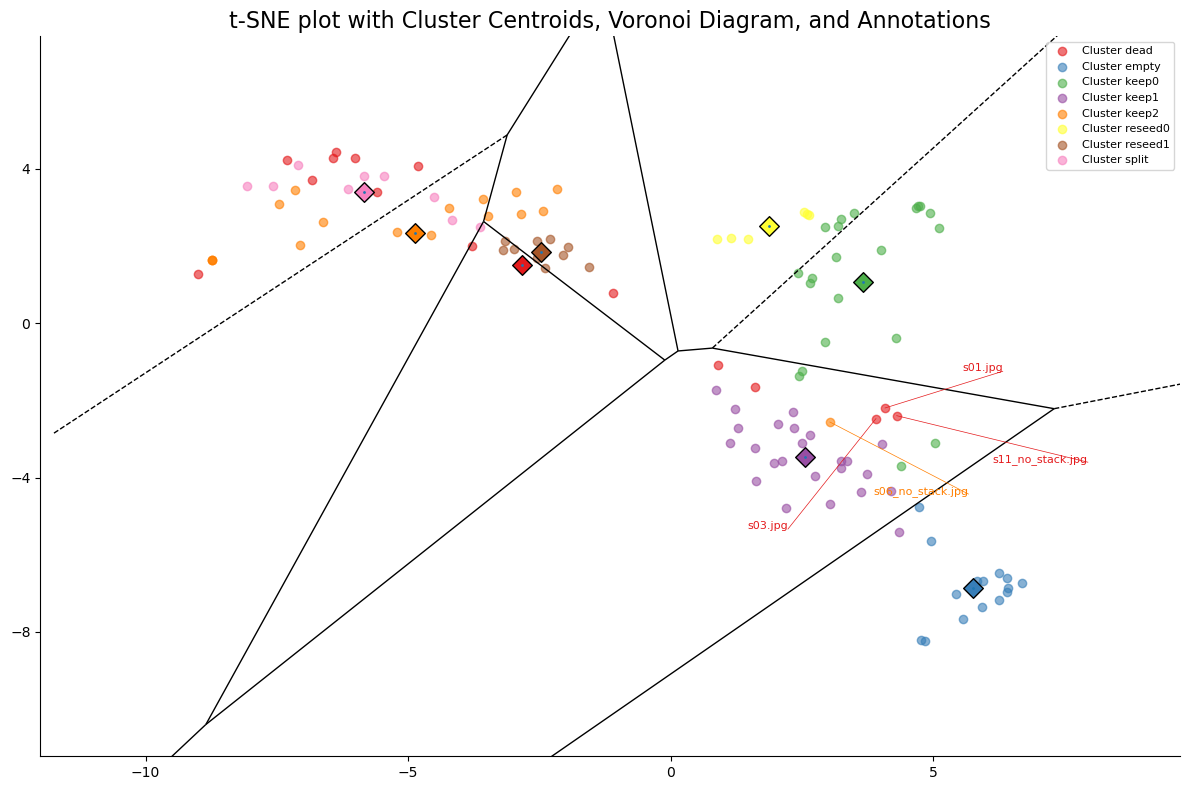

In [42]:
# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path("Segmentation") + csv_path)

data = data.drop(data[(data['count'] == 0) | (data['count'] == 1)].index)

# Save image names for later use in annotation
image_names = data['image_name']

# Dropping the 'image_name' column as it's not needed for t-SNE
features = data.drop('image_name', axis=1)

# Saving the labels for later use in the plot
labels = features['label']

data = features.copy()

# Dropping the 'label' column to scale only numerical features
features = features.drop('label', axis=1)

features = features[top_10_feature_names]

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Now let's perform t-SNE on the scaled features
tsne = TSNE(n_components=2, random_state=0)  # using 2 components for a 2D plot
# The fit might take a long time, depending on the size of your dataset
tsne_results = tsne.fit_transform(features_scaled)

unique_labels = np.unique(labels)
centroids = np.array([tsne_results[labels == label].mean(axis=0) for label in unique_labels])

vor = Voronoi(centroids)

# Start plot design enhancements here
fig, ax = plt.subplots(figsize=(12, 8))  # Larger figure size

# Step 4: Plot the t-SNE points and centroids
palette = plt.cm.Set1  # A nicer color map

for i, label in enumerate(unique_labels):
    points = tsne_results[labels == label]
    centroid = centroids[i]
    color = palette(i)
    
    ax.scatter(points[:, 0], points[:, 1], color=color, alpha=0.6, label=f'Cluster {label}')
    ax.scatter(centroid[0], centroid[1], color=color, edgecolors='black', marker='D', s=100)  # Diamond-shaped centroids

# Step 5: Overlay Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, point_size=2)

# Create a mapping from label to integer index
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Define function to get random label positions
def get_label_pos(point, offset=4.07):
    # Randomly choose an offset direction
    dx, dy = random.uniform(-offset, offset), random.uniform(-offset, offset)
    return point + np.array([dx, dy])

# Annotate far away points with lines
threshold = 7  # Define a suitable threshold
for i, (point, name, label) in enumerate(zip(tsne_results, image_names, data['label'])):
    centroid_index = label_to_index[label]
    centroid = centroids[centroid_index]
    distance = np.linalg.norm(point - centroid)

    if distance > threshold:
        # Get random label position
        label_pos = get_label_pos(point)

        # Get color for the cluster
        color = palette(centroid_index)

        # Draw a line from point to label with the same color as the cluster
        ax.plot([point[0], label_pos[0]], [point[1], label_pos[1]], color=color, linestyle='-', linewidth=0.5)

        # Place text at the random label position
        ax.text(label_pos[0], label_pos[1], name, fontsize=8, ha='right', color=color)

# Enhancements
ax.set_title('t-SNE plot with Cluster Centroids, Voronoi Diagram, and Annotations', fontsize=16)
ax.legend(fontsize=8, loc='upper right')
# Set axis limits to the range of t-SNE results to avoid excessive whitespace
x_min, x_max = tsne_results[:, 0].min() - 3, tsne_results[:, 0].max() + 3
y_min, y_max = tsne_results[:, 1].min() - 3, tsne_results[:, 1].max() + 3
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()


Successfully loaded data from D:/data_for_seg/
Successfully loaded data from E:/data_for_seg/


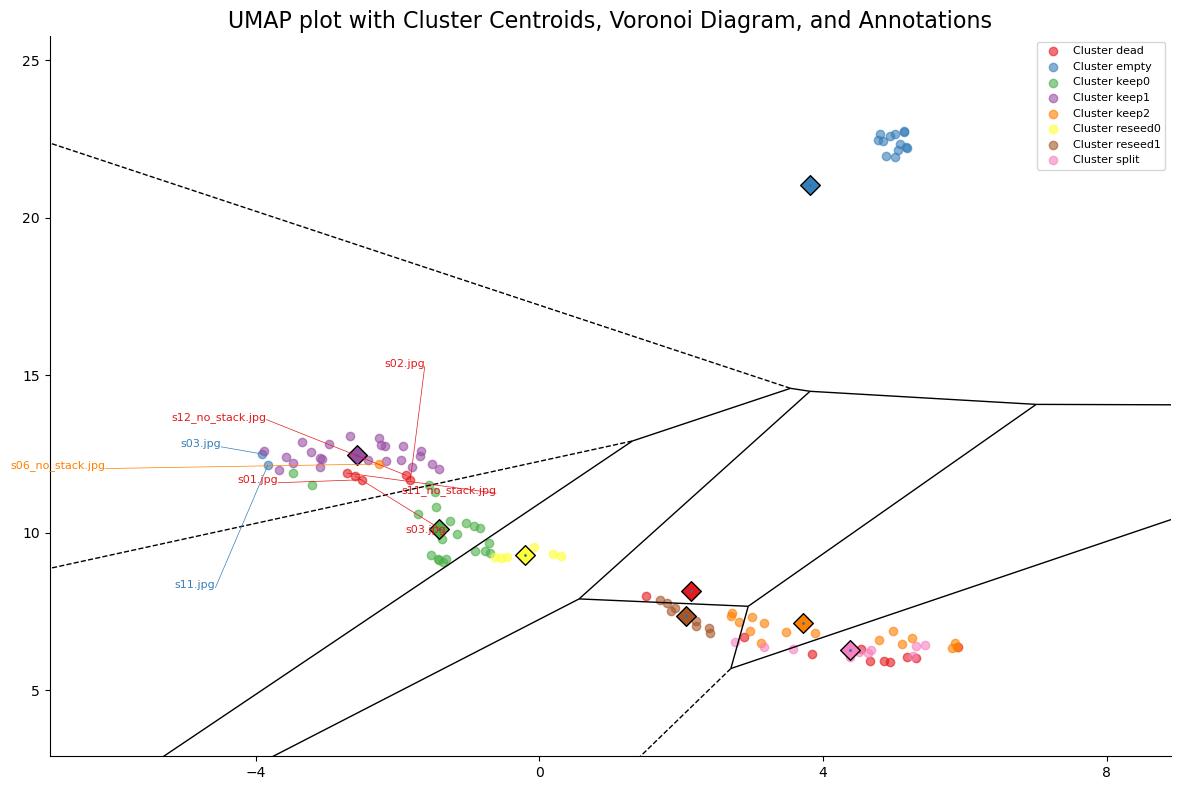

In [43]:
# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path("Segmentation") + csv_path)

data = data.drop(data[(data['count'] == 0) | (data['count'] == 1)].index)

# Save image names for later use in annotation
image_names = data['image_name']

# Dropping the 'image_name' and 'label' column
features = data.drop(['image_name', 'label'], axis=1)

# Select only top 10 features
features = features[top_10_feature_names]

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply UMAP
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42).fit_transform(features_scaled)

# Calculate centroids
unique_labels = np.unique(data['label'])
centroids = np.array([umap_results[data['label'] == label].mean(axis=0) for label in unique_labels])

# Calculate Voronoi
vor = Voronoi(centroids)

# Plot design
fig, ax = plt.subplots(figsize=(12, 8))

# Plot UMAP points and centroids
palette = plt.cm.Set1

for i, label in enumerate(unique_labels):
    points = umap_results[data['label'] == label]
    centroid = centroids[i]
    color = palette(i)
    
    ax.scatter(points[:, 0], points[:, 1], color=color, alpha=0.6, label=f'Cluster {label}')
    ax.scatter(centroid[0], centroid[1], color=color, edgecolors='black', marker='D', s=100)

# Overlay Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, point_size=2)

# Create a mapping from label to integer index
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Define function to get random label positions
def get_label_pos(point, offset=4.07):
    # Randomly choose an offset direction
    dx, dy = random.uniform(-offset, offset), random.uniform(-offset, offset)
    return point + np.array([dx, dy])

# Annotate far away points with lines
threshold = 5  # Define a suitable threshold
for i, (point, name, label) in enumerate(zip(umap_results, image_names, data['label'])):
    centroid_index = label_to_index[label]
    centroid = centroids[centroid_index]
    distance = np.linalg.norm(point - centroid)

    if distance > threshold:
        # Get random label position
        label_pos = get_label_pos(point)

        # Get color for the cluster
        color = palette(centroid_index)

        # Draw a line from point to label with the same color as the cluster
        ax.plot([point[0], label_pos[0]], [point[1], label_pos[1]], color=color, linestyle='-', linewidth=0.5)

        # Place text at the random label position
        ax.text(label_pos[0], label_pos[1], name, fontsize=8, ha='right', color=color)

# Enhancements
ax.set_title('UMAP plot with Cluster Centroids, Voronoi Diagram, and Annotations', fontsize=16)
ax.legend(fontsize=8, loc='upper right')
x_min, x_max = umap_results[:, 0].min() - 3, umap_results[:, 0].max() + 3
y_min, y_max = umap_results[:, 1].min() - 3, umap_results[:, 1].max() + 3
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()
